# Baseline simple detection model built from scratch

## Libraries

In [1]:
import os
import ast
import random
from dataclasses import dataclass
from typing import Optional, Tuple, List

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from torchvision.io import read_image
from torchvision.transforms import functional as F
from torchmetrics.detection.mean_ap import MeanAveragePrecision

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(22)
random.seed(22)
np.random.seed(22)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## Configuration

In [2]:
@dataclass
class TrainConfig:
    dataset_root: str = r"spark-2024-train-val"
    image_size: int = 256

    batch_size: int = 64
    num_workers: int = 0

    lr: float = 1e-3
    weight_decay: float = 1e-4
    max_epochs: int = 200

    bbox_loss_weight: float = 5.0

    # Train/val subsampling
    fraction: float = 0.10
    seed: int = 22

## Dataset

In [3]:
def parse_bbox_string(bbox_str: str):
    """Parse '(x1, y1, x2, y2)' into floats."""
    x1, y1, x2, y2 = ast.literal_eval(bbox_str)
    return float(x1), float(y1), float(x2), float(y2)


def collate_simple(batch):
    """Stack images and targets into tensors."""
    imgs, labels, bboxes = [], [], []
    for img, y, bb in batch:
        imgs.append(img)
        labels.append(y)
        bboxes.append(bb)
    return torch.stack(imgs), torch.tensor(labels, dtype=torch.long), torch.stack(bboxes).float()


class SparkCSVBBoxDataset(Dataset):
    """Load images + bbox + class label from CSV."""

    def __init__(self, root: str, split: str, image_size: int):
        self.root = root
        self.split = split
        self.image_size = image_size

        csv_path = os.path.join(root, f"{split}.csv")
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"Missing CSV: {csv_path}")

        self.df = pd.read_csv(csv_path)

        images_root = os.path.join(root, "images")
        if not os.path.exists(images_root):
            raise FileNotFoundError(f"Missing folder: {images_root}")

        self.class_names = sorted([
            d for d in os.listdir(images_root)
            if os.path.isdir(os.path.join(images_root, d))
        ])
        self.class_to_idx = {c: i for i, c in enumerate(self.class_names)}

        self.samples = []
        for _, row in self.df.iterrows():
            cls = str(row["Class"])
            img_name = str(row["Image name"])
            bbox_str = str(row["Bounding box"])

            img_path = os.path.join(root, "images", cls, split, img_name)
            self.samples.append((img_path, cls, bbox_str))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, cls, bbox_str = self.samples[idx]

        img = read_image(img_path).float() / 255.0
        x1, y1, x2, y2 = parse_bbox_string(bbox_str) # get coordinates of the bb
        bbox = torch.tensor([x1/1024, y1/1024, x2/1024, y2/1024]) # normalize bounding box
        img = F.resize(img, [self.image_size, self.image_size]) # resize image

        label = self.class_to_idx[cls]
        return img, label, bbox

## Lightning DataModule

In [4]:
class SparkDataModule(pl.LightningDataModule):
    """Lightning datamodule with reproducible subsampling."""

    def __init__(self, cfg: TrainConfig):
        super().__init__()
        self.cfg = cfg # conifig params

    def _subset(self, dataset, fraction, seed):
        ''' Return a random subset (fraction) of the dataset, using a seed. '''
        N = len(dataset)
        k = max(1, int(N * fraction))
        g = torch.Generator().manual_seed(seed)
        idx = torch.randperm(N, generator=g)[:k].tolist()
        return Subset(dataset, idx)

    def setup(self, stage: Optional[str] = None):
        ''' Load datasets and create subsets for train and val. '''
        train_full = SparkCSVBBoxDataset(self.cfg.dataset_root, "train", self.cfg.image_size)
        val_full = SparkCSVBBoxDataset(self.cfg.dataset_root, "val", self.cfg.image_size)

        self.ds_train = self._subset(train_full, self.cfg.fraction, self.cfg.seed)
        self.ds_val = self._subset(val_full, self.cfg.fraction, self.cfg.seed)

        self.class_names = train_full.class_names
        self.num_classes = len(self.class_names)

        print(f"Train subset: {len(self.ds_train)}/{len(train_full)} ({100*self.cfg.fraction:.1f}%)")
        print(f"Val subset:   {len(self.ds_val)}/{len(val_full)} ({100*self.cfg.fraction:.1f}%)")
        print("Num classes:", self.num_classes)

    def train_dataloader(self):
        return DataLoader(
            self.ds_train,
            batch_size=self.cfg.batch_size,
            shuffle=True,
            num_workers=self.cfg.num_workers,
            collate_fn=collate_simple,
        )

    def val_dataloader(self):
        return DataLoader(
            self.ds_val,
            batch_size=self.cfg.batch_size,
            shuffle=False,
            num_workers=self.cfg.num_workers,
            collate_fn=collate_simple,
        )

## Model Architecture

In [5]:
class ScratchDet(nn.Module):
    """Tiny CNN that outputs class logits and bbox coords."""

    def __init__(self, num_classes: int):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.class_head = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes), # we get the class logits
        )

        self.bbox_head = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 4),
            nn.Sigmoid(),  # outputs in [0,1], since we want normlaized coordinates
        )

    def forward(self, x):
        f = self.features(x)
        f = self.gap(f).view(f.size(0), -1)
        return self.class_head(f), self.bbox_head(f)

## Lightning module

In [6]:
class LitScratchDet(pl.LightningModule):
    """Lightning wrapper: loss, optimizer, and validation metrics."""

    def __init__(self, cfg, num_classes):
        super().__init__()
        self.cfg = cfg
        self.model = ScratchDet(num_classes)

        self.ce = nn.CrossEntropyLoss() # for the class
        self.l1 = nn.SmoothL1Loss() # for the bbox

        self.map_metric = MeanAveragePrecision(iou_type="bbox")

    def training_step(self, batch, batch_idx):
        x, y, bb = batch
        logits, bb_pred = self.model(x) # forward pass

        loss_cls = self.ce(logits, y)
        loss_bb = self.l1(bb_pred, bb)
        loss = loss_cls + self.cfg.bbox_loss_weight * loss_bb # weighted sum of the two losses

        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train/loss", loss, prog_bar=True)
        self.log("train/acc", acc, prog_bar=True)

        # debug print to make sure i choose the right value for bbox loss weight
        if batch_idx % 50 == 0:
            print(
                f"[batch {batch_idx}] "
                f"loss_cls={loss_cls.item():.4f} | "
                f"lambda*loss_bb={(self.cfg.bbox_loss_weight * loss_bb).item():.4f} | "
                f"loss_total={loss.item():.4f}"
            )

        return loss

    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        x, y, bb = batch
        logits, bb_pred = self.model(x) # forward pass

        loss_cls = self.ce(logits, y)
        loss_bb = self.l1(bb_pred, bb)
        loss = loss_cls + self.cfg.bbox_loss_weight * loss_bb # weighted sum of the two losses

        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val/loss", loss, prog_bar=True)
        self.log("val/acc", acc, prog_bar=True)

        if self.map_metric is None:
            return

        # Calculate mAP in COCO format
        probs = torch.softmax(logits, dim=1)
        scores, pred_labels = torch.max(probs, dim=1)

        B, _, H, W = x.shape
        preds, targets = [], []
        for i in range(B):
            pr = bb_pred[i]
            gt = bb[i]

            pr_xyxy = torch.tensor([pr[0]*W, pr[1]*H, pr[2]*W, pr[3]*H],
                                   dtype=torch.float32, device=self.device).unsqueeze(0)
            gt_xyxy = torch.tensor([gt[0]*W, gt[1]*H, gt[2]*W, gt[3]*H],
                                   dtype=torch.float32, device=self.device).unsqueeze(0)

            preds.append({
                "boxes": pr_xyxy,
                "scores": scores[i].unsqueeze(0),
                "labels": pred_labels[i].unsqueeze(0),
            })
            targets.append({
                "boxes": gt_xyxy,
                "labels": y[i].unsqueeze(0),
            })

        self.map_metric.update(preds, targets)

    def on_validation_epoch_end(self):
        if self.map_metric is None:
            return
        m = self.map_metric.compute()
        self.log("val/map50", m["map_50"], prog_bar=True)
        self.log("val/map50_95", m["map"], prog_bar=True)
        self.map_metric.reset()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.weight_decay)

## Model Setup

In [7]:
cfg = TrainConfig(
    dataset_root=r"spark-2024-train-val",
    image_size=256,
    batch_size=64,
    num_workers=0,
    lr=1e-3,
    weight_decay=1e-4,
    max_epochs=200,
    bbox_loss_weight=10,
    fraction=0.10,
    seed=22,
)

dm = SparkDataModule(cfg)
dm.setup()

model = LitScratchDet(cfg, num_classes=dm.num_classes).to(device)

Train subset: 6000/60000 (10.0%)
Val subset:   2000/20000 (10.0%)
Num classes: 10


In [8]:
from torchinfo import summary
summary(
    model.model,   # <-- la TinyDetNet / ScratchDetNet
    input_size=(1, 3, cfg.image_size, cfg.image_size),
)

Layer (type:depth-idx)                   Output Shape              Param #
ScratchDet                               [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 8, 8]             --
│    └─Conv2d: 2-1                       [1, 16, 128, 128]         1,216
│    └─ReLU: 2-2                         [1, 16, 128, 128]         --
│    └─MaxPool2d: 2-3                    [1, 16, 64, 64]           --
│    └─Conv2d: 2-4                       [1, 32, 32, 32]           4,640
│    └─ReLU: 2-5                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-6                    [1, 32, 16, 16]           --
│    └─Conv2d: 2-7                       [1, 64, 8, 8]             18,496
│    └─ReLU: 2-8                         [1, 64, 8, 8]             --
├─AdaptiveAvgPool2d: 1-2                 [1, 64, 1, 1]             --
├─Sequential: 1-3                        [1, 10]                   --
│    └─Linear: 2-9                       [1, 64]                   4,160
│ 

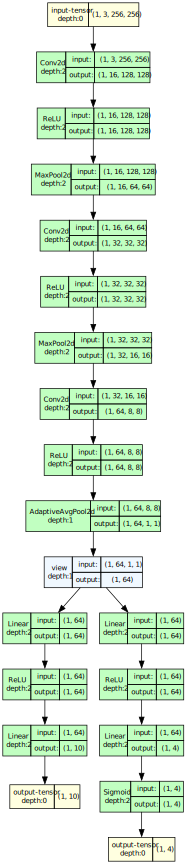

In [9]:
from torchview import draw_graph

model_graph = draw_graph(model.model, input_size=(1, 3, cfg.image_size, cfg.image_size), expand_nested=False) # generate graph
model_graph.visual_graph # display

## Training

In [10]:
checkpoint_cb = ModelCheckpoint(
    dirpath="checkpoints",
    monitor="val/map50_95",
    mode="max",
    save_top_k=1,
    filename="tinydet-best-{epoch:02d}",
)

earlystop_cb = EarlyStopping(
    monitor="val/map50_95",
    mode="max",
    patience=20,
    min_delta=0.0,
    verbose=True,
)

trainer = pl.Trainer(
    max_epochs=cfg.max_epochs,
    accelerator="auto",
    devices="auto",
    logger=False,
    num_sanity_val_steps=0,
    callbacks=[checkpoint_cb, earlystop_cb],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [96]:
trainer.fit(model, dm)

c:\Users\tomma\anaconda3\envs\py310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Users\tomma\OneDrive - Universita degli Studi Roma Tre\Desktop\AI_LUX\CV\PROJECT_SPARK\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                 | Params | Mode 
------------------------------------------------------------
0 | model      | ScratchDet           | 33.6 K | train
1 | ce         | CrossEntropyLoss     | 0      | train
2 | l1         | SmoothL1Loss         | 0      | train
3 | map_metric | MeanAveragePrecision | 0      | train
------------------------------------------------------------
33.6 K    Trainable params
0         Non-trainable params
33.6 K    Total params
0.134     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Train subset: 6000/60000 (10.0%)
Val subset:   2000/20000 (10.0%)
Num classes: 10


c:\Users\tomma\anaconda3\envs\py310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
c:\Users\tomma\anaconda3\envs\py310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=2.2953 | lambda*loss_bb=0.3188 | loss_total=2.6141
[batch 50] loss_cls=2.2975 | lambda*loss_bb=0.1865 | loss_total=2.4840


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved. New best score: 0.000


[batch 0] loss_cls=2.3045 | lambda*loss_bb=0.1970 | loss_total=2.5014
[batch 50] loss_cls=2.3055 | lambda*loss_bb=0.1736 | loss_total=2.4790


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=2.3059 | lambda*loss_bb=0.1836 | loss_total=2.4895
[batch 50] loss_cls=2.3045 | lambda*loss_bb=0.1598 | loss_total=2.4643


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.000


[batch 0] loss_cls=2.3000 | lambda*loss_bb=0.1956 | loss_total=2.4955
[batch 50] loss_cls=2.2964 | lambda*loss_bb=0.1561 | loss_total=2.4524


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=2.2916 | lambda*loss_bb=0.1797 | loss_total=2.4714
[batch 50] loss_cls=2.2970 | lambda*loss_bb=0.1831 | loss_total=2.4801


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=2.3058 | lambda*loss_bb=0.2202 | loss_total=2.5259
[batch 50] loss_cls=2.2793 | lambda*loss_bb=0.1860 | loss_total=2.4653


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=2.2406 | lambda*loss_bb=0.1866 | loss_total=2.4272
[batch 50] loss_cls=2.1700 | lambda*loss_bb=0.1742 | loss_total=2.3442


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.9649 | lambda*loss_bb=0.1689 | loss_total=2.1338
[batch 50] loss_cls=1.9410 | lambda*loss_bb=0.1922 | loss_total=2.1332


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.000


[batch 0] loss_cls=1.7544 | lambda*loss_bb=0.2168 | loss_total=1.9712
[batch 50] loss_cls=1.7600 | lambda*loss_bb=0.1863 | loss_total=1.9463


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.001


[batch 0] loss_cls=1.6578 | lambda*loss_bb=0.1683 | loss_total=1.8261
[batch 50] loss_cls=1.7730 | lambda*loss_bb=0.1669 | loss_total=1.9400


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.5060 | lambda*loss_bb=0.1837 | loss_total=1.6898
[batch 50] loss_cls=1.5174 | lambda*loss_bb=0.1578 | loss_total=1.6752


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.5359 | lambda*loss_bb=0.2089 | loss_total=1.7448
[batch 50] loss_cls=1.6133 | lambda*loss_bb=0.1611 | loss_total=1.7744


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.4558 | lambda*loss_bb=0.1645 | loss_total=1.6202
[batch 50] loss_cls=1.5322 | lambda*loss_bb=0.2004 | loss_total=1.7326


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.001


[batch 0] loss_cls=1.4687 | lambda*loss_bb=0.1867 | loss_total=1.6554
[batch 50] loss_cls=1.5715 | lambda*loss_bb=0.1759 | loss_total=1.7475


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.001


[batch 0] loss_cls=1.4993 | lambda*loss_bb=0.1790 | loss_total=1.6783
[batch 50] loss_cls=1.5176 | lambda*loss_bb=0.1804 | loss_total=1.6980


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.4963 | lambda*loss_bb=0.1788 | loss_total=1.6751
[batch 50] loss_cls=1.4509 | lambda*loss_bb=0.2019 | loss_total=1.6528


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.6838 | lambda*loss_bb=0.1498 | loss_total=1.8336
[batch 50] loss_cls=1.3876 | lambda*loss_bb=0.1610 | loss_total=1.5486


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.001


[batch 0] loss_cls=1.3552 | lambda*loss_bb=0.2016 | loss_total=1.5568
[batch 50] loss_cls=1.6138 | lambda*loss_bb=0.1422 | loss_total=1.7561


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.2385 | lambda*loss_bb=0.1452 | loss_total=1.3837
[batch 50] loss_cls=1.3043 | lambda*loss_bb=0.1826 | loss_total=1.4869


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.001


[batch 0] loss_cls=1.4937 | lambda*loss_bb=0.1796 | loss_total=1.6733
[batch 50] loss_cls=1.3215 | lambda*loss_bb=0.1837 | loss_total=1.5052


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.001


[batch 0] loss_cls=1.1878 | lambda*loss_bb=0.1670 | loss_total=1.3548
[batch 50] loss_cls=1.4442 | lambda*loss_bb=0.1892 | loss_total=1.6333


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.3830 | lambda*loss_bb=0.1713 | loss_total=1.5542
[batch 50] loss_cls=1.2874 | lambda*loss_bb=0.1768 | loss_total=1.4642


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.3145 | lambda*loss_bb=0.1741 | loss_total=1.4886
[batch 50] loss_cls=1.2515 | lambda*loss_bb=0.1901 | loss_total=1.4416


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.2806 | lambda*loss_bb=0.1691 | loss_total=1.4497
[batch 50] loss_cls=0.8953 | lambda*loss_bb=0.1498 | loss_total=1.0451


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.2371 | lambda*loss_bb=0.1610 | loss_total=1.3981
[batch 50] loss_cls=1.1818 | lambda*loss_bb=0.1954 | loss_total=1.3772


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.0877 | lambda*loss_bb=0.1613 | loss_total=1.2490
[batch 50] loss_cls=1.3333 | lambda*loss_bb=0.1561 | loss_total=1.4894


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.001


[batch 0] loss_cls=1.0239 | lambda*loss_bb=0.1547 | loss_total=1.1785
[batch 50] loss_cls=1.1050 | lambda*loss_bb=0.1816 | loss_total=1.2866


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.9805 | lambda*loss_bb=0.1605 | loss_total=1.1410
[batch 50] loss_cls=1.1516 | lambda*loss_bb=0.1813 | loss_total=1.3328


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.1215 | lambda*loss_bb=0.1689 | loss_total=1.2904
[batch 50] loss_cls=1.1957 | lambda*loss_bb=0.1775 | loss_total=1.3733


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.001


[batch 0] loss_cls=1.0927 | lambda*loss_bb=0.1348 | loss_total=1.2275
[batch 50] loss_cls=1.0530 | lambda*loss_bb=0.1642 | loss_total=1.2172


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.9677 | lambda*loss_bb=0.1879 | loss_total=1.1556
[batch 50] loss_cls=1.0459 | lambda*loss_bb=0.1419 | loss_total=1.1878


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.001


[batch 0] loss_cls=0.8571 | lambda*loss_bb=0.1626 | loss_total=1.0197
[batch 50] loss_cls=0.9889 | lambda*loss_bb=0.1526 | loss_total=1.1415


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.002


[batch 0] loss_cls=0.9956 | lambda*loss_bb=0.1429 | loss_total=1.1385
[batch 50] loss_cls=1.0786 | lambda*loss_bb=0.1419 | loss_total=1.2205


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.002


[batch 0] loss_cls=1.0052 | lambda*loss_bb=0.1766 | loss_total=1.1818
[batch 50] loss_cls=1.0351 | lambda*loss_bb=0.1510 | loss_total=1.1861


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.0008 | lambda*loss_bb=0.1584 | loss_total=1.1592
[batch 50] loss_cls=1.0391 | lambda*loss_bb=0.1867 | loss_total=1.2257


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.1099 | lambda*loss_bb=0.1869 | loss_total=1.2968
[batch 50] loss_cls=0.9337 | lambda*loss_bb=0.1719 | loss_total=1.1056


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.9306 | lambda*loss_bb=0.1718 | loss_total=1.1024
[batch 50] loss_cls=1.0848 | lambda*loss_bb=0.1489 | loss_total=1.2338


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.9869 | lambda*loss_bb=0.1515 | loss_total=1.1384
[batch 50] loss_cls=1.1154 | lambda*loss_bb=0.1475 | loss_total=1.2629


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.9052 | lambda*loss_bb=0.1473 | loss_total=1.0525
[batch 50] loss_cls=1.0236 | lambda*loss_bb=0.1851 | loss_total=1.2087


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.8903 | lambda*loss_bb=0.1906 | loss_total=1.0809
[batch 50] loss_cls=0.9328 | lambda*loss_bb=0.1503 | loss_total=1.0831


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.8459 | lambda*loss_bb=0.1914 | loss_total=1.0374
[batch 50] loss_cls=1.1064 | lambda*loss_bb=0.1419 | loss_total=1.2482


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.8043 | lambda*loss_bb=0.1523 | loss_total=0.9566
[batch 50] loss_cls=0.9967 | lambda*loss_bb=0.1618 | loss_total=1.1586


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.8851 | lambda*loss_bb=0.1632 | loss_total=1.0483
[batch 50] loss_cls=0.8727 | lambda*loss_bb=0.1576 | loss_total=1.0303


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.002


[batch 0] loss_cls=1.0003 | lambda*loss_bb=0.1546 | loss_total=1.1549
[batch 50] loss_cls=0.7513 | lambda*loss_bb=0.1693 | loss_total=0.9206


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.8046 | lambda*loss_bb=0.1759 | loss_total=0.9805
[batch 50] loss_cls=0.8957 | lambda*loss_bb=0.1793 | loss_total=1.0750


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.0231 | lambda*loss_bb=0.1683 | loss_total=1.1914
[batch 50] loss_cls=0.9547 | lambda*loss_bb=0.1725 | loss_total=1.1272


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.9015 | lambda*loss_bb=0.1714 | loss_total=1.0729
[batch 50] loss_cls=1.0125 | lambda*loss_bb=0.1747 | loss_total=1.1872


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.8605 | lambda*loss_bb=0.1470 | loss_total=1.0075
[batch 50] loss_cls=0.9085 | lambda*loss_bb=0.1662 | loss_total=1.0747


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.8779 | lambda*loss_bb=0.1676 | loss_total=1.0455
[batch 50] loss_cls=0.9703 | lambda*loss_bb=0.1669 | loss_total=1.1372


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.7738 | lambda*loss_bb=0.1836 | loss_total=0.9575
[batch 50] loss_cls=0.7586 | lambda*loss_bb=0.1650 | loss_total=0.9236


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.8380 | lambda*loss_bb=0.1550 | loss_total=0.9930
[batch 50] loss_cls=0.8379 | lambda*loss_bb=0.1695 | loss_total=1.0074


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.0565 | lambda*loss_bb=0.1458 | loss_total=1.2023
[batch 50] loss_cls=0.7421 | lambda*loss_bb=0.1741 | loss_total=0.9162


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.6577 | lambda*loss_bb=0.1698 | loss_total=0.8275
[batch 50] loss_cls=0.7962 | lambda*loss_bb=0.1454 | loss_total=0.9416


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.7493 | lambda*loss_bb=0.1466 | loss_total=0.8959
[batch 50] loss_cls=0.6754 | lambda*loss_bb=0.1502 | loss_total=0.8256


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.9240 | lambda*loss_bb=0.1538 | loss_total=1.0778
[batch 50] loss_cls=0.7501 | lambda*loss_bb=0.1649 | loss_total=0.9150


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.8618 | lambda*loss_bb=0.1464 | loss_total=1.0082
[batch 50] loss_cls=0.7911 | lambda*loss_bb=0.1767 | loss_total=0.9678


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.002


[batch 0] loss_cls=0.8076 | lambda*loss_bb=0.1608 | loss_total=0.9683
[batch 50] loss_cls=0.6880 | lambda*loss_bb=0.1510 | loss_total=0.8389


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.001 >= min_delta = 0.0. New best score: 0.003


[batch 0] loss_cls=0.8715 | lambda*loss_bb=0.1598 | loss_total=1.0313
[batch 50] loss_cls=0.7717 | lambda*loss_bb=0.1711 | loss_total=0.9428


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=1.1286 | lambda*loss_bb=0.1453 | loss_total=1.2739
[batch 50] loss_cls=0.7141 | lambda*loss_bb=0.1609 | loss_total=0.8749


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.7445 | lambda*loss_bb=0.1521 | loss_total=0.8966
[batch 50] loss_cls=0.6010 | lambda*loss_bb=0.1563 | loss_total=0.7573


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.7548 | lambda*loss_bb=0.1559 | loss_total=0.9108
[batch 50] loss_cls=0.7234 | lambda*loss_bb=0.1563 | loss_total=0.8798


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.6377 | lambda*loss_bb=0.1601 | loss_total=0.7977
[batch 50] loss_cls=0.7282 | lambda*loss_bb=0.1654 | loss_total=0.8935


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.9222 | lambda*loss_bb=0.1544 | loss_total=1.0766
[batch 50] loss_cls=0.6578 | lambda*loss_bb=0.1850 | loss_total=0.8428


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.7126 | lambda*loss_bb=0.1342 | loss_total=0.8468
[batch 50] loss_cls=0.9151 | lambda*loss_bb=0.1452 | loss_total=1.0603


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.7099 | lambda*loss_bb=0.1625 | loss_total=0.8724
[batch 50] loss_cls=0.7744 | lambda*loss_bb=0.1794 | loss_total=0.9538


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.8193 | lambda*loss_bb=0.1634 | loss_total=0.9827
[batch 50] loss_cls=0.5781 | lambda*loss_bb=0.1619 | loss_total=0.7400


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.7565 | lambda*loss_bb=0.1393 | loss_total=0.8959
[batch 50] loss_cls=0.6376 | lambda*loss_bb=0.1679 | loss_total=0.8055


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.5406 | lambda*loss_bb=0.1538 | loss_total=0.6944
[batch 50] loss_cls=0.6912 | lambda*loss_bb=0.1767 | loss_total=0.8679


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.6278 | lambda*loss_bb=0.1470 | loss_total=0.7748
[batch 50] loss_cls=0.6221 | lambda*loss_bb=0.1652 | loss_total=0.7873


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.6633 | lambda*loss_bb=0.1645 | loss_total=0.8278
[batch 50] loss_cls=0.6741 | lambda*loss_bb=0.1484 | loss_total=0.8226


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.6360 | lambda*loss_bb=0.1482 | loss_total=0.7841
[batch 50] loss_cls=0.6145 | lambda*loss_bb=0.1644 | loss_total=0.7789


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.8315 | lambda*loss_bb=0.1550 | loss_total=0.9864
[batch 50] loss_cls=0.6863 | lambda*loss_bb=0.1717 | loss_total=0.8580


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.5135 | lambda*loss_bb=0.1492 | loss_total=0.6627
[batch 50] loss_cls=0.7387 | lambda*loss_bb=0.1461 | loss_total=0.8848


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.6829 | lambda*loss_bb=0.1762 | loss_total=0.8591
[batch 50] loss_cls=0.6412 | lambda*loss_bb=0.1534 | loss_total=0.7946


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4367 | lambda*loss_bb=0.1538 | loss_total=0.5905
[batch 50] loss_cls=0.8493 | lambda*loss_bb=0.1317 | loss_total=0.9810


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.6900 | lambda*loss_bb=0.1690 | loss_total=0.8590
[batch 50] loss_cls=0.6525 | lambda*loss_bb=0.1590 | loss_total=0.8114


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.5535 | lambda*loss_bb=0.1476 | loss_total=0.7011
[batch 50] loss_cls=0.6923 | lambda*loss_bb=0.1989 | loss_total=0.8912


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.003


[batch 0] loss_cls=0.5936 | lambda*loss_bb=0.1355 | loss_total=0.7291
[batch 50] loss_cls=0.7702 | lambda*loss_bb=0.1723 | loss_total=0.9425


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.5306 | lambda*loss_bb=0.1310 | loss_total=0.6617
[batch 50] loss_cls=0.8492 | lambda*loss_bb=0.1889 | loss_total=1.0381


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.6696 | lambda*loss_bb=0.1688 | loss_total=0.8385
[batch 50] loss_cls=0.6168 | lambda*loss_bb=0.1716 | loss_total=0.7884


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.5996 | lambda*loss_bb=0.1592 | loss_total=0.7589
[batch 50] loss_cls=0.5374 | lambda*loss_bb=0.1348 | loss_total=0.6722


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.8221 | lambda*loss_bb=0.1419 | loss_total=0.9640
[batch 50] loss_cls=0.5706 | lambda*loss_bb=0.1760 | loss_total=0.7466


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.5987 | lambda*loss_bb=0.1547 | loss_total=0.7534
[batch 50] loss_cls=0.6454 | lambda*loss_bb=0.1548 | loss_total=0.8002


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.6887 | lambda*loss_bb=0.1496 | loss_total=0.8382
[batch 50] loss_cls=0.5147 | lambda*loss_bb=0.1524 | loss_total=0.6672


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.7961 | lambda*loss_bb=0.1509 | loss_total=0.9471
[batch 50] loss_cls=0.5525 | lambda*loss_bb=0.1407 | loss_total=0.6932


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4782 | lambda*loss_bb=0.1424 | loss_total=0.6206
[batch 50] loss_cls=0.6773 | lambda*loss_bb=0.1490 | loss_total=0.8263


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.6058 | lambda*loss_bb=0.1463 | loss_total=0.7521
[batch 50] loss_cls=0.5637 | lambda*loss_bb=0.1793 | loss_total=0.7430


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.003


[batch 0] loss_cls=0.4380 | lambda*loss_bb=0.1335 | loss_total=0.5715
[batch 50] loss_cls=0.3689 | lambda*loss_bb=0.1681 | loss_total=0.5369


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.7124 | lambda*loss_bb=0.1495 | loss_total=0.8620
[batch 50] loss_cls=0.5567 | lambda*loss_bb=0.1503 | loss_total=0.7070


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4239 | lambda*loss_bb=0.1429 | loss_total=0.5668
[batch 50] loss_cls=0.4797 | lambda*loss_bb=0.1439 | loss_total=0.6236


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.5683 | lambda*loss_bb=0.1480 | loss_total=0.7163
[batch 50] loss_cls=0.3711 | lambda*loss_bb=0.1540 | loss_total=0.5251


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4410 | lambda*loss_bb=0.1465 | loss_total=0.5875
[batch 50] loss_cls=0.5531 | lambda*loss_bb=0.1420 | loss_total=0.6951


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4610 | lambda*loss_bb=0.1523 | loss_total=0.6133
[batch 50] loss_cls=0.6362 | lambda*loss_bb=0.1567 | loss_total=0.7929


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4598 | lambda*loss_bb=0.1446 | loss_total=0.6045
[batch 50] loss_cls=0.4558 | lambda*loss_bb=0.1312 | loss_total=0.5870


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.6979 | lambda*loss_bb=0.1453 | loss_total=0.8433
[batch 50] loss_cls=0.5464 | lambda*loss_bb=0.1281 | loss_total=0.6745


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4988 | lambda*loss_bb=0.1822 | loss_total=0.6810
[batch 50] loss_cls=0.5067 | lambda*loss_bb=0.1270 | loss_total=0.6337


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.5575 | lambda*loss_bb=0.1528 | loss_total=0.7103
[batch 50] loss_cls=0.5736 | lambda*loss_bb=0.1724 | loss_total=0.7460


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.5526 | lambda*loss_bb=0.1503 | loss_total=0.7029
[batch 50] loss_cls=0.5240 | lambda*loss_bb=0.1569 | loss_total=0.6809


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4196 | lambda*loss_bb=0.1180 | loss_total=0.5376
[batch 50] loss_cls=0.6590 | lambda*loss_bb=0.1463 | loss_total=0.8053


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.3716 | lambda*loss_bb=0.1365 | loss_total=0.5081
[batch 50] loss_cls=0.3555 | lambda*loss_bb=0.1401 | loss_total=0.4956


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.004


[batch 0] loss_cls=0.5054 | lambda*loss_bb=0.1321 | loss_total=0.6375
[batch 50] loss_cls=0.4833 | lambda*loss_bb=0.1564 | loss_total=0.6397


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.5433 | lambda*loss_bb=0.1420 | loss_total=0.6854
[batch 50] loss_cls=0.5117 | lambda*loss_bb=0.1426 | loss_total=0.6543


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.5130 | lambda*loss_bb=0.1569 | loss_total=0.6698
[batch 50] loss_cls=0.4439 | lambda*loss_bb=0.1380 | loss_total=0.5819


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.5019 | lambda*loss_bb=0.1406 | loss_total=0.6424
[batch 50] loss_cls=0.4141 | lambda*loss_bb=0.1491 | loss_total=0.5632


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.5203 | lambda*loss_bb=0.1388 | loss_total=0.6590
[batch 50] loss_cls=0.4691 | lambda*loss_bb=0.1470 | loss_total=0.6162


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4366 | lambda*loss_bb=0.1435 | loss_total=0.5802
[batch 50] loss_cls=0.4666 | lambda*loss_bb=0.1397 | loss_total=0.6063


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.3583 | lambda*loss_bb=0.1548 | loss_total=0.5131
[batch 50] loss_cls=0.4188 | lambda*loss_bb=0.1510 | loss_total=0.5698


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.5527 | lambda*loss_bb=0.1449 | loss_total=0.6976
[batch 50] loss_cls=0.3722 | lambda*loss_bb=0.1595 | loss_total=0.5317


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4455 | lambda*loss_bb=0.1598 | loss_total=0.6053
[batch 50] loss_cls=0.5789 | lambda*loss_bb=0.1536 | loss_total=0.7325


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.2836 | lambda*loss_bb=0.1188 | loss_total=0.4025
[batch 50] loss_cls=0.5442 | lambda*loss_bb=0.1530 | loss_total=0.6973


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/map50_95 improved by 0.000 >= min_delta = 0.0. New best score: 0.004


[batch 0] loss_cls=0.4677 | lambda*loss_bb=0.1563 | loss_total=0.6240
[batch 50] loss_cls=0.4679 | lambda*loss_bb=0.1193 | loss_total=0.5872


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4964 | lambda*loss_bb=0.1590 | loss_total=0.6554
[batch 50] loss_cls=0.3557 | lambda*loss_bb=0.1513 | loss_total=0.5070


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4258 | lambda*loss_bb=0.1604 | loss_total=0.5862
[batch 50] loss_cls=0.5957 | lambda*loss_bb=0.1589 | loss_total=0.7546


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4353 | lambda*loss_bb=0.1453 | loss_total=0.5806
[batch 50] loss_cls=0.3759 | lambda*loss_bb=0.1376 | loss_total=0.5135


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4626 | lambda*loss_bb=0.1424 | loss_total=0.6050
[batch 50] loss_cls=0.3632 | lambda*loss_bb=0.1497 | loss_total=0.5129


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.2654 | lambda*loss_bb=0.1532 | loss_total=0.4186
[batch 50] loss_cls=0.3797 | lambda*loss_bb=0.1248 | loss_total=0.5046


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4409 | lambda*loss_bb=0.1338 | loss_total=0.5748
[batch 50] loss_cls=0.3530 | lambda*loss_bb=0.1441 | loss_total=0.4970


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4170 | lambda*loss_bb=0.1626 | loss_total=0.5796
[batch 50] loss_cls=0.5172 | lambda*loss_bb=0.1404 | loss_total=0.6576


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4164 | lambda*loss_bb=0.1375 | loss_total=0.5539
[batch 50] loss_cls=0.2684 | lambda*loss_bb=0.1376 | loss_total=0.4060


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.3467 | lambda*loss_bb=0.1460 | loss_total=0.4927
[batch 50] loss_cls=0.4785 | lambda*loss_bb=0.1495 | loss_total=0.6280


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.5002 | lambda*loss_bb=0.1331 | loss_total=0.6334
[batch 50] loss_cls=0.3944 | lambda*loss_bb=0.1337 | loss_total=0.5281


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.3046 | lambda*loss_bb=0.1082 | loss_total=0.4127
[batch 50] loss_cls=0.4792 | lambda*loss_bb=0.1663 | loss_total=0.6455


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.3480 | lambda*loss_bb=0.1262 | loss_total=0.4742
[batch 50] loss_cls=0.6786 | lambda*loss_bb=0.1285 | loss_total=0.8071


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.3532 | lambda*loss_bb=0.1391 | loss_total=0.4924
[batch 50] loss_cls=0.3914 | lambda*loss_bb=0.1105 | loss_total=0.5019


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.4512 | lambda*loss_bb=0.1311 | loss_total=0.5823
[batch 50] loss_cls=0.6003 | lambda*loss_bb=0.1652 | loss_total=0.7654


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.2503 | lambda*loss_bb=0.1483 | loss_total=0.3986
[batch 50] loss_cls=0.3760 | lambda*loss_bb=0.1357 | loss_total=0.5117


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.3963 | lambda*loss_bb=0.1280 | loss_total=0.5243
[batch 50] loss_cls=0.5689 | lambda*loss_bb=0.1289 | loss_total=0.6978


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.2691 | lambda*loss_bb=0.1447 | loss_total=0.4138
[batch 50] loss_cls=0.2191 | lambda*loss_bb=0.1343 | loss_total=0.3534


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.2691 | lambda*loss_bb=0.1346 | loss_total=0.4037
[batch 50] loss_cls=0.3645 | lambda*loss_bb=0.1526 | loss_total=0.5171


Validation: |          | 0/? [00:00<?, ?it/s]

[batch 0] loss_cls=0.2948 | lambda*loss_bb=0.1161 | loss_total=0.4108
[batch 50] loss_cls=0.2936 | lambda*loss_bb=0.1430 | loss_total=0.4366


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/map50_95 did not improve in the last 20 records. Best score: 0.004. Signaling Trainer to stop.


## Model Evaluation

In [37]:
best_model = LitScratchDet.load_from_checkpoint(
    "checkpoints\\tinydet-best-112-0.0000.ckpt",
    cfg=cfg,
    num_classes=dm.num_classes,
)
best_model = best_model.to(device)
best_model.eval()

LitScratchDet(
  (model): ScratchDet(
    (features): Sequential(
      (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
    )
    (gap): AdaptiveAvgPool2d(output_size=(1, 1))
    (class_head): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=10, bias=True)
    )
    (bbox_head): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=4, bias=True)
      (3): Sigmoid()
    )
  )
  (ce): CrossEntropyLoss()
  (l1): SmoothL1L

In [33]:
best_model2 = LitScratchDet.load_from_checkpoint(
    "checkpoints\\tinydet-best-epoch=109.ckpt",
    cfg=cfg,
    num_classes=dm.num_classes,
)
best_model2 = best_model2.to(device)

In [34]:
trainer.validate(best_model, datamodule=dm, verbose=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train subset: 6000/60000 (10.0%)
Val subset:   2000/20000 (10.0%)
Num classes: 10


c:\Users\tomma\anaconda3\envs\py310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val/acc          │    0.8105000257492065     │
│         val/loss          │    0.6855773329734802     │
│         val/map50         │   0.013928131200373173    │
│       val/map50_95        │   0.0035535867791622877   │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 0.6855773329734802,
  'val/acc': 0.8105000257492065,
  'val/map50': 0.013928131200373173,
  'val/map50_95': 0.0035535867791622877}]

In [35]:
trainer.validate(best_model2, datamodule=dm, verbose=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train subset: 6000/60000 (10.0%)
Val subset:   2000/20000 (10.0%)
Num classes: 10


c:\Users\tomma\anaconda3\envs\py310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val/acc          │    0.7839999794960022     │
│         val/loss          │    0.7375208735466003     │
│         val/map50         │   0.018391726538538933    │
│       val/map50_95        │   0.0039933486841619015   │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 0.7375208735466003,
  'val/acc': 0.7839999794960022,
  'val/map50': 0.018391726538538933,
  'val/map50_95': 0.0039933486841619015}]

In [38]:
best_model.eval()

val_loader = dm.val_dataloader()
target_names = dm.class_names

all_y_true, all_y_pred, all_scores = [], [], []
all_bb_true, all_bb_pred = [], []

with torch.no_grad():
    for x, y, bb in val_loader:
        x = x.to(device)
        logits, bb_pred = best_model.model(x)

        probs = torch.softmax(logits, dim=1)
        scores, pred_cls = torch.max(probs, dim=1)

        all_y_true.extend(y.cpu().tolist())
        all_y_pred.extend(pred_cls.cpu().tolist())
        all_scores.extend(scores.cpu().tolist())

        all_bb_true.append(bb.cpu())
        all_bb_pred.append(bb_pred.cpu())

all_bb_true = torch.cat(all_bb_true, dim=0)
all_bb_pred = torch.cat(all_bb_pred, dim=0)

In [39]:
print("\n## Classification report")
print(classification_report(all_y_true, all_y_pred, target_names=target_names, digits=4))


## Classification report
                 precision    recall  f1-score   support

         Cheops     0.7524    0.8289    0.7888       187
 LisaPathfinder     0.8973    0.8877    0.8925       187
ObservationSat1     0.8407    0.7500    0.7927       204
         Proba2     0.8824    0.9091    0.8955       198
         Proba3     0.8824    0.8612    0.8717       209
      Proba3ocs     0.8868    0.7540    0.8150       187
         Smart1     0.7359    0.8252    0.7780       206
           Soho     0.8367    0.8410    0.8389       195
   VenusExpress     0.7729    0.7583    0.7656       211
     XMM Newton     0.6726    0.7037    0.6878       216

       accuracy                         0.8105      2000
      macro avg     0.8160    0.8119    0.8126      2000
   weighted avg     0.8140    0.8105    0.8110      2000



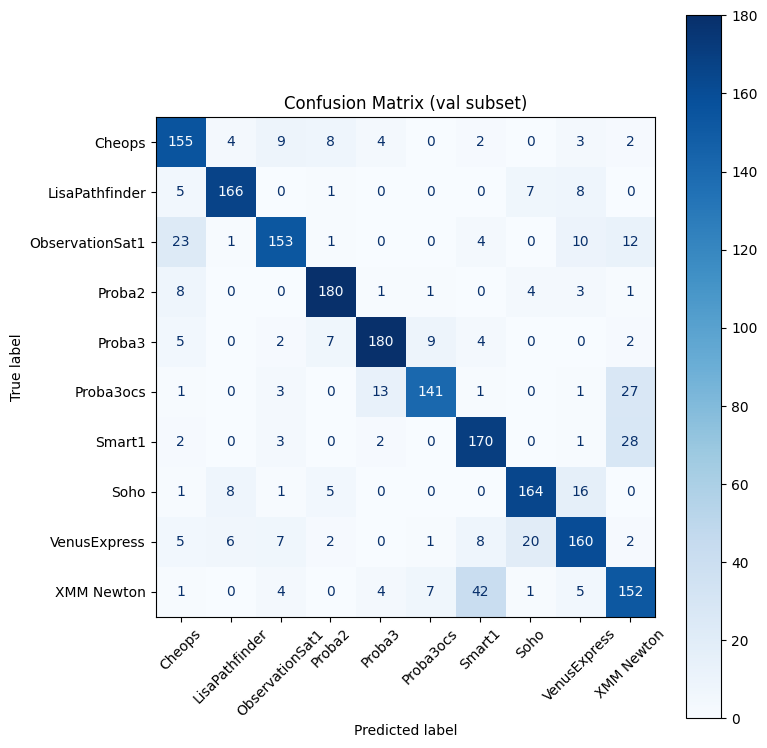

In [40]:
cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, values_format="d")
ax.set_title("Confusion Matrix (val subset)")
plt.tight_layout()
plt.show()

## IoU helpers

In [41]:
def denorm_xyxy(bb_norm, W, H):
    """ Convert normalized xyxy bbox to pixel xyxy."""
    x1 = float(bb_norm[0]) * W
    y1 = float(bb_norm[1]) * H
    x2 = float(bb_norm[2]) * W
    y2 = float(bb_norm[3]) * H
    return (x1, y1, x2, y2)


def iou_xyxy(a, b):
    """Compute IoU between two pixel xyxy boxes."""
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b

    inter_x1 = max(ax1, bx1)
    inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2)
    inter_y2 = min(ay2, by2)

    inter_w = max(0.0, inter_x2 - inter_x1)
    inter_h = max(0.0, inter_y2 - inter_y1)
    inter_area = inter_w * inter_h

    area_a = max(0.0, ax2 - ax1) * max(0.0, ay2 - ay1)
    area_b = max(0.0, bx2 - bx1) * max(0.0, by2 - by1)

    union = area_a + area_b - inter_area
    if union <= 0.0:
        return 0.0
    return inter_area / union


def draw_box(ax, box_xyxy, color, text):
    """Draw a bbox with a small label."""
    x1, y1, x2, y2 = box_xyxy
    w = max(0.0, x2 - x1)
    h = max(0.0, y2 - y1)
    ax.add_patch(plt.Rectangle((x1, y1), w, h, fill=False, linewidth=2, edgecolor=color))
    ax.text(x1, max(0.0, y1 - 5), text, color=color, fontsize=10,
            bbox=dict(facecolor="black", alpha=0.5, pad=2))

## Show a random validation sample with IoU ≥ 0.70

In [42]:
rng = random.Random(cfg.seed)

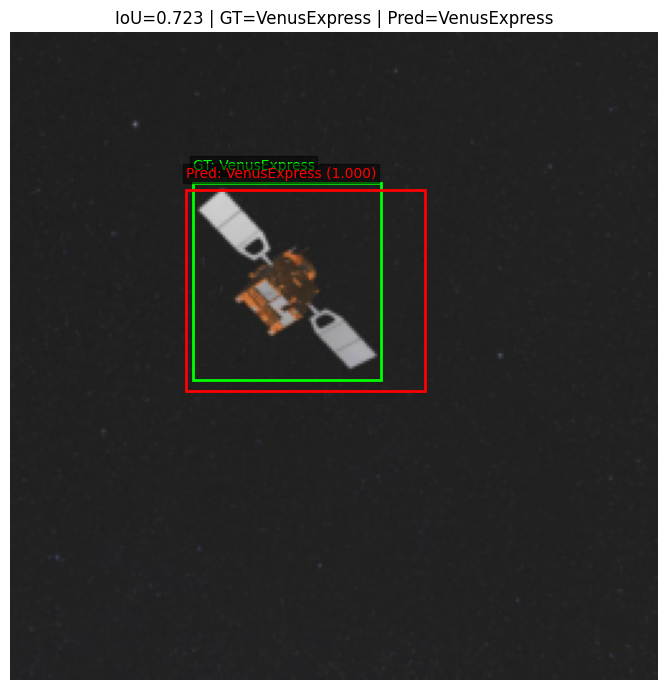

In [45]:
min_iou = 0.70

candidates = []
with torch.no_grad():
    for x, y, bb in dm.val_dataloader():
        x = x.to(device)
        y = y.to(device)
        bb = bb.to(device)

        logits, bb_pred = best_model.model(x)
        probs = torch.softmax(logits, dim=1)
        scores, pred_cls = torch.max(probs, dim=1)

        B, _, H, W = x.shape
        for i in range(B):
            gt_px = denorm_xyxy(bb[i].detach().cpu(), W, H)
            pr_px = denorm_xyxy(bb_pred[i].detach().cpu(), W, H)
            iou = iou_xyxy(gt_px, pr_px)

            if iou >= min_iou:
                candidates.append({
                    "img": x[i].detach().cpu(),
                    "y_gt": int(y[i].item()),
                    "y_pred": int(pred_cls[i].item()),
                    "score": float(scores[i].item()),
                    "gt_px": gt_px,
                    "pr_px": pr_px,
                    "iou": float(iou),
                })

if len(candidates) == 0:
    print(f"No samples found with IoU >= {min_iou}.")
else:
    c = rng.choice(candidates)

    img_np = c["img"].permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0.0, 1.0)

    gt_name = target_names[c["y_gt"]]
    pr_name = target_names[c["y_pred"]]

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img_np)
    ax.axis("off")

    draw_box(ax, c["gt_px"], "lime", f"GT: {gt_name}")
    draw_box(ax, c["pr_px"], "red", f"Pred: {pr_name} ({c['score']:.3f})")

    ax.set_title(f"IoU={c['iou']:.3f} | GT={gt_name} | Pred={pr_name}")
    plt.tight_layout()
    plt.show()

## IoU distribution (CDF)

IoU mean: 0.1959051638841629
IoU median: 0.16303983330726624
IoU >= 0.50: 0.065
IoU >= 0.70: 0.009


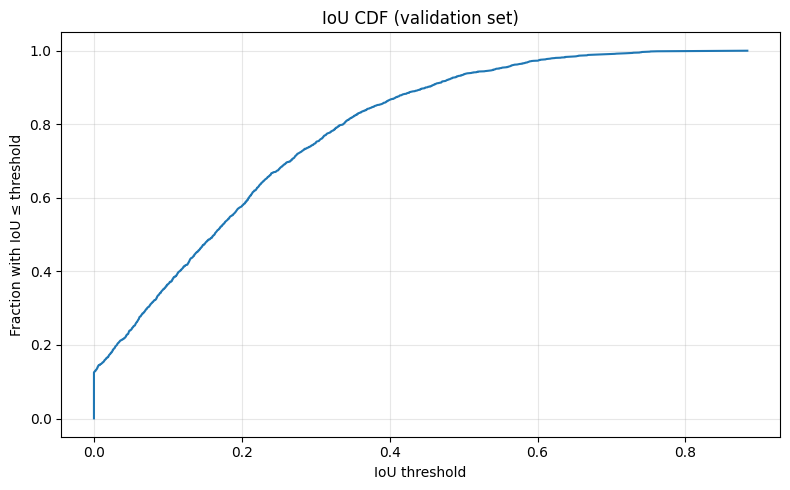

In [44]:
ious = []
with torch.no_grad():
    for x, y, bb in dm.val_dataloader():
        x = x.to(device)
        bb = bb.to(device)

        logits, bb_pred = best_model.model(x)

        B, _, H, W = x.shape
        for i in range(B):
            gt_px = denorm_xyxy(bb[i].detach().cpu(), W, H)
            pr_px = denorm_xyxy(bb_pred[i].detach().cpu(), W, H)
            ious.append(iou_xyxy(gt_px, pr_px))

ious = np.array(ious, dtype=np.float32)
print("IoU mean:", float(ious.mean()))
print("IoU median:", float(np.median(ious)))
print("IoU >= 0.50:", float((ious >= 0.50).mean()))
print("IoU >= 0.70:", float((ious >= 0.70).mean()))

ious_sorted = np.sort(ious)
cdf = np.arange(1, len(ious_sorted) + 1) / len(ious_sorted)

plt.figure(figsize=(8, 5))
plt.plot(ious_sorted, cdf)
plt.xlabel("IoU threshold")
plt.ylabel("Fraction with IoU ≤ threshold")
plt.title("IoU CDF (validation set)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()